## Simplificar flujos de trabajos con pipelines

El concepto de los _pipelines_ es muy sencillo de entender: ajustar varios pasos de transformacion, uno seguido de otro, de tal manera que todos los pasos individuales se condencen en un solo paso global.

Pra esta parte trabajaremos con el archivo `Breast Cancer Wisconsin` del cual se puede obtener informacion desde la pagina web: https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)

df.columns = ['ID', 'Diagnosis']+ list(np.arange(1, 31))
df.head()

,ID,Diagnosis,1,2,3,4,5,6,7,8,...,21,22,23,24,25,26,27,28,29,30
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
from sklearn.preprocessing import LabelEncoder

X = df.iloc[:, 2:].values
y = df.iloc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

In [5]:
le.transform(['M', 'B'])

array([1, 0], dtype=int64)

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=1)

In [7]:
# Usando pipelines para combinar procesos: escalamiento, PCA, modelado de datos
# =============================================================================
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(), PCA(n_components=2), LogisticRegression())

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print(f'Test Accuracy: {np.round(pipe_lr.score(X_test, y_test), 4)}')

Test Accuracy: 0.9561


IMPORTANTE: La funcion `make_pipeline` puede tomar un numero arbitrario de transformadores de scikit learn (objetos que soportan `fit` y `transform` como entrada) seguido de un estimador de scikit learn que implemente los metodos `fit` y `predict`. El estimador siempre debe ir al final, y siempre debe existir.

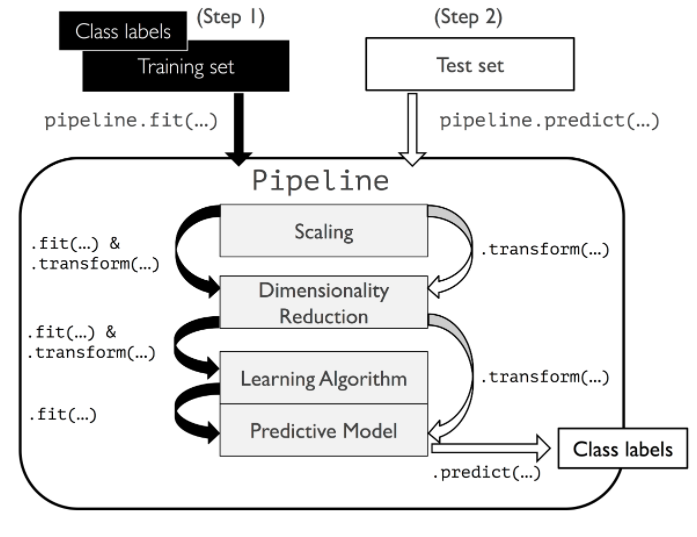

<div class="burk">
EJERCICIO</div><i class="fa fa-lightbulb-o "></i>

Utilice los datos anteriores junto con el pipeline generado para realizar la prediccion de los datos y evaluar el rendimiento de los conjuntos de entrenamiento y test.

In [9]:
from sklearn.metrics import accuracy_score
y_pred_train = pipe_lr.predict(X_train)
print(f'Precision entrenamiento: {accuracy_score(y_train, y_pred_train)}')

Precision entrenamiento: 0.9538461538461539


In [10]:
y_pred_test = pipe_lr.predict(X_test)
print(f'Precision prueba: {accuracy_score(y_test, y_pred_test)}')

Precision prueba: 0.956140350877193


## Utilizar validacion cruzada de K iteraciones paramejorar el rendimiento del modelo

El objetivo de esta tecnica es generar estimaciones fiables para la generalizacion del modelo a datos no vistos durante el entrenamiento, buscando evitar el subajuste y el sobreajuste.

En esta tecnica, se divide aleatoriamente el conjunto de datos de entrenamiento en k iteraciones sin reemplazo, donde k-1 iteraciones se utilizan para el entrenamiento del modelo y una iteracion para la evaluacion del rendimiento. Este proceso se repite k veces para obtener k modelos y estimaciones del rendimiento. 

Despues calculamos el rendimiento medio de los modelos basado en distintas e independientes iteraciones para obtener una estimacion del rendimiento que es menos sensible a la subdivision de datos. Esta tecnica se usa generalmente para la seleccion de modelos, es decir. la eleccion optima de los hiperparametros para el modelo.

Una vez se han encontrado los valores optimos de los hiperparametros, se puede volver a entrenar el modelo en el conjunto de entrenamiento completo y obtener una estimacion del rendimiento final mediante el conjunto de prueba independiente. Lo anterior se basa en el hecho de que proporcionar mas datos de entrenamiento a un modelo lo vuelva mas robusto y preciso.

El siguiente ejemplo se basa en una estimacion con k=10. El conjunto de entrenamiento esta dividido en 10 iteraciones, 9 para entrenar y 1 para evaluar el rendimiento. Ademas los rendimientos $E_i$ para cada iteracion se utilizan para calcular el rendimiento estimado medio del modelo:

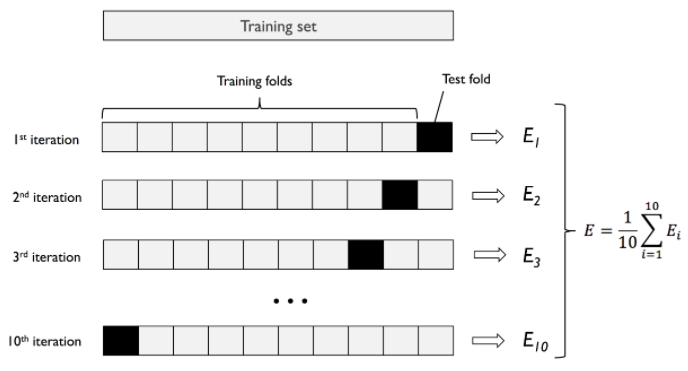

In [11]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator = pipe_lr, X = X_train, y = y_train, cv = 10, n_jobs = -1)
print(f'Preciciosnes del modelo CV: {scores}')
print(f'Precision del modelo CV: {np.round(np.mean(scores), 4)} +/- {np.round(np.std(scores), 4)}')

Preciciosnes del modelo CV: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
Precision del modelo CV: 0.9495 +/- 0.0139


In [12]:
scores = cross_val_score(estimator = pipe_lr, X = X_test, y = y_test, cv = 10, n_jobs = -1)
print(f'Preciciosnes del modelo CV: {scores}')
print(f'Precision del modelo CV: {np.round(np.mean(scores), 4)} +/- {np.round(np.std(scores), 4)}')

Preciciosnes del modelo CV: [1.         0.91666667 0.91666667 0.91666667 1.         1.
 0.90909091 0.90909091 1.         1.        ]
Precision del modelo CV: 0.9568 +/- 0.0433


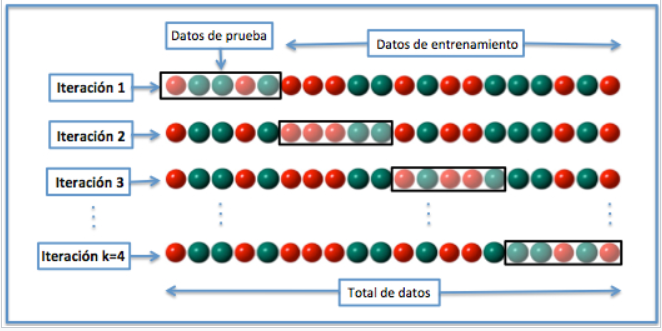

https://es.wikipedia.org/wiki/Validaci%C3%B3n_cruzada#:~:text=La%20validaci%C3%B3n%20cruzada%20o%20cross,datos%20de%20entrenamiento%20y%20prueba.

## Depurar algoritmos con curvas de validacion y aprendizaje

Las curvas de aprendizaje nos ayudan a evaluar cuando un modelo presenta alta varianza o alto sesgo; recoger mas muestras de entrenamiento podrian ser una solucion a estos problemas, pero es una forma costosa y dificil de ejecutar para resolverlos, y no siempre funciona. Por lo tanto es importante saber tomar una decision correcta acerca de esta alternativa de solucion; resulta que las curvas de aprendizaje tambien nos ayudan a saber cuando el aumento en la cantidad de datos de entrenamiento funciona para nuestros propositos.
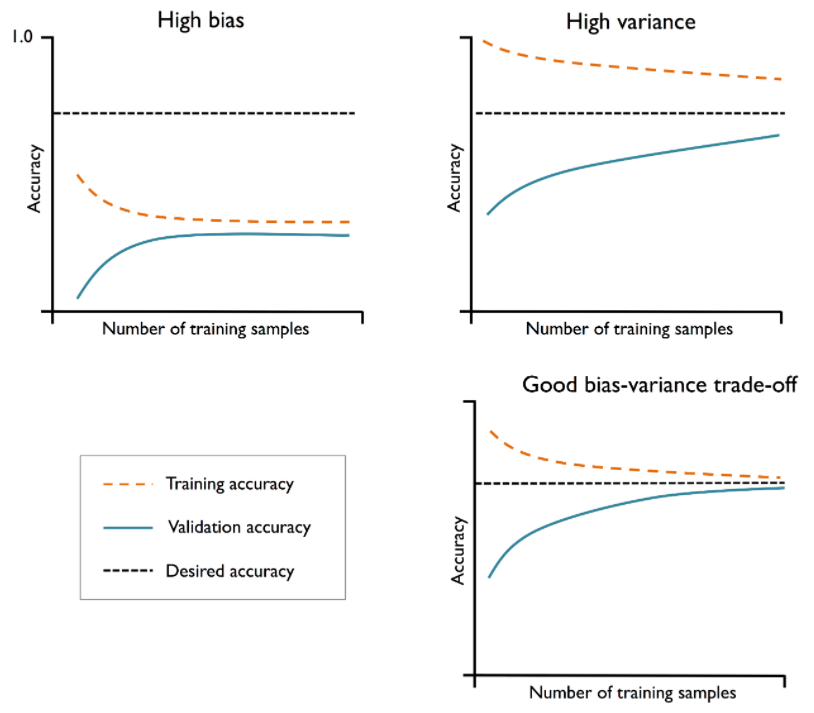

La grafica superior izquierda muestra un alto grado de **subajuste**; esto se puede corregir de varias maneras: 

1. Aumentar el numero de parametros del modelo
2. Recoger o construir caracteristicas adicionales
3. Reducir el grado de regularizacion

La grafica superior derecha presenta **alta varianza**, lo cual se nota por la alta separacion entre la curvas de precision de entrenamiento y de validacion cruzada. Para corregir este problema, tenemos:

1. Recoger mas datos de entrenamiento
2. Reducir la complejidad del modelo
3. Aumentar el parametro de regularizacion

Para los modelo no regularizados tambien puede ser util la reduccion de dimensionalidad, ya se por seleccion de caracteristicas o por extraccion.

Recoger mas datos de entrenamiento puede ayudar a reducir el sobreajuste, pero no siempre, por ejemplo en modelos muy ruidosos o en aquellos que ya esten cerca de su valor optimo. 

* **Curva de prendizaje (Learning Curve):**  Determina puntajes de prueba y entrenamiento con validación cruzada para diferentes tamaños de conjuntos de entrenamiento. 
    
    Un generador de validación cruzada divide todo el conjunto de datos k veces en datos de entrenamiento y prueba. Se utilizarán subconjuntos del conjunto de entrenamiento con diferentes tamaños para entrenar al estimador y se calculará una puntuación para cada tamaño de subconjunto de entrenamiento y el conjunto de prueba. Posteriormente, las puntuaciones se promediarán sobre todas las k carreras para cada tamaño de subconjunto de entrenamiento.


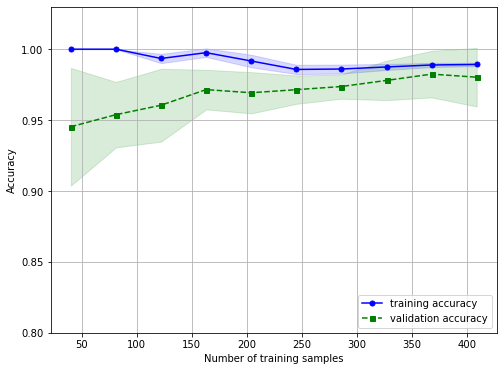

In [13]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve


pipe_lr = make_pipeline(StandardScaler(), LogisticRegression(penalty='l2'))

train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr, X=X_train, y=y_train, 
                                                        train_sizes=np.linspace(0.1, 1.0, 10), cv=10, n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig, ax = plt.subplots(figsize = (8, 6))

ax.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
ax.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

ax.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
ax.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Number of training samples')
ax.set_ylabel('Accuracy')
ax.legend(loc='lower right')
ax.set_ylim([0.8, 1.03]);

Se puede ver que el modelo funciona muy bien para muestras de tamaño superior a 250 muestras y que para menos muestras la precision del conjunto de entrenamiento aumenta, mientras que las curvas se separan, indicando esto un aumento del sobreajuste.

## Resolver el sobreajuste y el subajuste con curvas de validacion

Las curvas de validacion son herramientas que permiten aumentar el rendimiento del algoritmo solventando problemas con el subajuste y el sobreajuste.

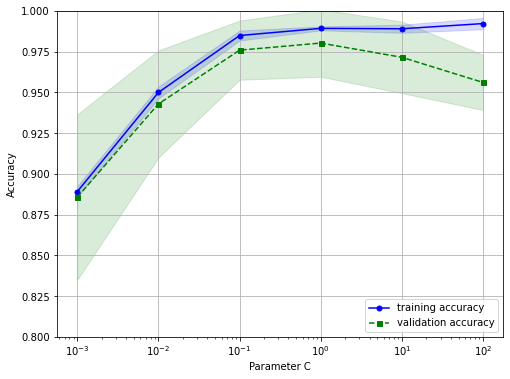

In [16]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import validation_curve

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(estimator=pipe_lr, X=X_train, y=y_train, 
                param_name='logisticregression__C', param_range=param_range, cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig, ax = plt.subplots(figsize = (8, 6))

ax.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
ax.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

ax.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
ax.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

ax.grid()
ax.set_xscale('log')
ax.legend(loc='lower right')
ax.set_xlabel('Parameter C')
ax.set_ylabel('Accuracy')
ax.set_ylim([0.8, 1.0]);


<div class="burk">
EJERCICIOS</div><i class="fa fa-lightbulb-o "></i>

Vamos a utilizar el archivo `Social_Network_Ads.csv` para practicar un poco de lo visto hasta ahora. El archivo tiene las siguientes columnas

    User ID, Gender, Age, EstimatedSalary, Purchased
    
Buscamos segmentar clientes por algunas de sus caracteristicas y asi evaluar si realizara una cierta compra o no lo hara. La etiqueta de clase estara dada por `Purchased` y las demas columnas seran las columnas de caracterisitcas. Explore el dataset. Ajuste las etiquetas de datos categoricas. Cree un pipeline para escalar y ajustar las caracteristicas a un cierto modelo de clasificacion. Elija el modelo que quiera. Cree una curva de aprendizaje y saque sus conclusiones.

Cree tambien una curva de validacion y elija el parametro a variar. Podria intentar por ejemplo usar el modelo SVC, y crear una curva de validacion para C y lambda. Recuerde que para SVC, C es un parametro que tiene que ver con el ancho del margen: entre mayor sea C mas estrictos somos con el control de los errores, haciendo que C sea menor, y aumentando la posibilidad de sobreajuste. Lambda es un parametro de regularizacion; entre mas grande sea, mas estricto sera el control sobre los pesos, lo que puede llevar a un subajuste.

## Ajustar los modelos de aprendizaje con busqueda por cuadriculas

La idea de esta tecnica es muy sencilla: se eligen los hiperparametros a optimizar, y los valores que se desean probar; el algoritmo hara una busqueda exhaustiva por fuerxa bruta para encontrar la mejor combinacion de hiperparametros:

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(), SVC())

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [{'svc__C': param_range, 
               'svc__kernel': ['linear']},
              {'svc__C': param_range, 
               'svc__gamma': param_range, 
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy', cv=10, n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

In [ ]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print(f'Precision de prueba: {clf.score(X_test, y_test)}')

<div class="burk">
EJERCICIO</div><i class="fa fa-lightbulb-o "></i>

1. Clasifique el dataset del ejercicio anterior usando bosques aleatorios. Optimice los hiperparametros n_estimators y max_depth. Cree una curva de aprendizaje para cada uno, para asi evaluar la posibilidad de sobreajuste y subajuste y realice un grid search. 

## Seleccion de algoritmos con validacion cruzada

En la validacion cruzada anidada tenemos un bucle de validacion cruzada de k iteraciones externo para dividir los datos en iteraciones de prueba y entrenamiento, y un bucle interno para la seleccion del modelo mediante la validacion cruzada de k iteraciones dentro de la iteracion del entrenamiento. Despues de la seleccion del modelo, la iteracion de prueba se utiliza para evaluar el rendimiento del modelo.

En la siguiente imagen se muestra una iteracion cruzada anidada con un 5 iteraciones externas y 2 internas, lo cual puede ser util para conjuntos de datos grandes en donde el coste computacional es importante. Este tipo de configuracion se conoce como **validacion cruzada 5x2**:

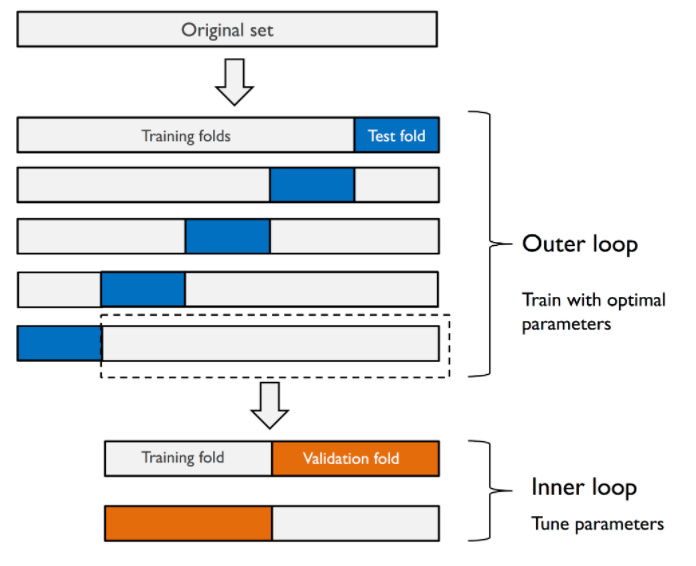

In [ ]:
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy', cv=2)

scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),  np.std(scores)))

In [ ]:
from sklearn.tree import DecisionTreeClassifier

gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring='accuracy',  cv=2)

scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))